## A Reinforcement Learning Based Approach to Demand Prediction and Location Optimization of Electric Vehicle Charging Stations in New York

## Introduction

In recent years, significant advances have been made in smart grid technology and renewable energies in order to reduce reliance on fossil fuels, which emit harmful greenhouse gases. Along with these advances in power generation and distribution, electric vehicles (EVs) have also been increasingly adopted in cities throughout the U.S. However, effective strategies are necessary to build charging infrastructure to meet this new demand for EVs, and there are still many challenges that hinder the further expansion of EV usage. 

One issue is the convenience and accessibility of charging stations - the distribution of charging stations is not always effective, and with variations in charging demand and battery sizes, there is a need for charging stations to account for a rising number of EV users while maintaining efficiency. More substantial changes to usage patterns due to population changes or even the COVID-19 pandemic can also add to the difficulty of predicting where charging stations would be most effective. Thus, charging station infrastructure can still be improved.

## Related Work

There has been substantial research in the realm of EVs and optimizing placement of charging stations, but there is not as much existing work that has addressed the specific issue of placing charging stations with a reinforcement learning approach. EV charging demand is predicted with Canonical Correlation Analysis (CCA) in Gopalakrishnan et al. (2016), utilizing auxiliary data such as Points of Interest (PoI), which are nearby buildings and institutions that could influence demand, and traffic density. 

In Almaghrebi et al. (2020), EV charging demand is predicted with supervised machine learning methods such as gradient boosting, support vector machines, and random forest as displayed below.

<p align=“center”>
    <center><img src=demand.png width=“400" height=“400” /></center>
</p>

Additionally, Wagner et al. (2013) optimizes EV charging station locations by sectioning off areas in Amsterdam that could serve as potential charging spots, forming a grid. The attractiveness of placing charge points in these areas is based on data from nearby points of interest, which is closely related to charging demand. The example below illustrates the idea of creating a grid and analyzing points of interest around potential charging locations. 

<p align=“center”>
    <center><img src=grid.png width=“400" height=“400” /></center>
</p>

A reinforcement learning based model would allow an agent to account for many different factors, such as energy consumption, charging times, budget, or coverage, while automatically navigating the environment and learning an optimal placement of charging stations in the areas with the highest demand.

## Reinforcement Learning (RL) Background

Reinforcement Learning is an area of machine learning that focuses on having an autonomous agent interact with an environment and learn to make decisions on its own. By performing actions in  the environment, the agent receives feedback from the environment--its reward--and learns to improve future actions. RL problems are typically modeled with the **Markov Decision Process (MDP)** shown below.

<p align=“center”>
    <center><img src=markov.png width=“400" height=“400” /></center>
</p>

In the standard RL setting, the agent will continually receive a state $s_t$ from the environment and will follow a policy $\pi$ in order to select an action $a_t$, with the goal of maximizing the return from each state. This return incorporates a reward $r_t$ which can be obtained from certain actions, and is represented by 

$$Q^{\pi}(s,a)=\mathbb{E}[R_t|s_t=s,a_t=a], $$ 

also known as the **action-value function**. $R_t$ denotes the reward function, and is defined by 

$$R_t=\sum_{i=0}^{\infty} \gamma^i r_{t+i},$$

where $r_t$ is the expected reward at time step $t$ and $\gamma$ is the **discount factor**, which determines how much importance the agent will place on future rewards compared to current rewards. The **optimal value function**, $Q^{*}(s,a)$, represents the maximum possible action value and is defined by 

$$Q^{*}(s,a)=\max Q^{\pi}(s,a).$$ 

One of the most common RL algorithms, Q-learning, is a **value-based method** that attempts to directly estimate the optimal value function. This is done by iteratively minimizing a sequence of loss functions and updating the value function based on the reward received from moving to the next state. Other RL methods build an explicit representation of the agent's policy, known as **policy-based methods**, and still others combine an the value-based approach with the policy-based approach into **actor-critic** type algorithms. In our proposed framework, we experiment with multiple types of these RL algorithms to optimize charging station locations

## Methods

Our approach to improve the accessibility of these charging stations is to utilize reinforcement learning to predict the expected demand at multiple locations, and to then choose optimal locations to deploy new charging stations to satisfy that demand. The goal is to maximize the coverage of new charging stations (meaning that the station is accessible to EVs within a certain distance) and minimize total costs using a predetermined budget as to ensure an efficient use of resources. Our model should also be able to adapt to new data that may show increases or decreases in overall EV usage and demand. By analyzing a variety of factors, the model will learn a useful strategy for placing charging stations.

We plan to set up an environment as described above and test multiple RL algorithms, taking into account the following factors:
- Historical usage data from existing charging stations
- Nearby points that could influence demand (e.g. schools, shops, hospitals, etc.)
- Traffic data from nearby intersections
- Average range of electric vehicles
- Costs of deploying a new charging station (e.g. licensing, number and type of charging slots)
- Charging station wait times and pricing
- EV network
- Other factors that could influence demand (hourly changes, peak demand, seasonal changes)

We plan to use two different models throughout our methods. The first model will predict energy demand by using the above factors as inputs, using supervised and unsupervised machine learning methods to find correlations in the data. This model will result in a heatmap that shows areas with high and low demand across a given region in New York. 

Then, our RL model will interact with this heatmap in addition to other factors in order to learn the best locations to place charging stations to meet the charging demand. After placing down a charging station, the first model will be called again to update the heatmap with new demand, given that there is a new charging station at the location selected by the RL agent.

### Cleaning Data

We use data from EValuateNY, a tool created by Atlas Public Policy that collects a wide variety of electric vehicle data and charging data from all over New York State. In addition, to consider traffic data, we use raw data from the New York Department of Transportation.

To obtain a dataset of all the EV charging stations in New York, we combine data from two different sources. One is straight from the EValuateNY database:

In [10]:
import pandas as pd

data1 = pd.read_csv('ny_stations_clean.csv')
data1.sort_values(by=['ID'])
data1.head()

REDC         County ZIP Code          Station Name     ID  \
0  Western New York    Erie County    14226     AAA Car Care Plus  42992   
1  Western New York    Erie County    14221     AAA Car Care Plus  42993   
2        Mid-Hudson  Orange County    12550        Thruway Nissan  44174   
3     Mohawk Valley  Otsego County    13820  Country Club Imports  44176   
4  Western New York    Erie County    14127      West-Herr Nissan  44178   

   Level 2 Ports  Level 2 Locations  DCFC Ports  DCFC Locations     EV Network  
0            1.0                1.0         NaN             NaN  Non-Networked  
1            1.0                1.0         NaN             NaN  Non-Networked  
2            1.0                1.0         NaN             NaN  Non-Networked  
3            2.0                1.0         2.0             1.0  Non-Networked  
4            1.0                1.0         NaN             NaN  Non-Networked

Although there is useful information about individual stations here, we eventually would like to have the latitude and longitude for each station to simplify later visualizations and maps, and possibly the street addresses for future integration with other mapping software. Thus, data is also pulled from the U.S. Department of Energy's Alternative Fuels Data Center:

In [16]:
data2 = pd.read_csv('station_locations_AFDC.csv')
data2.columns

data2 = data2[['Fuel Type Code', 'Station Name', 'Street Address', 'City', 'State', 'ZIP','Status Code', 
                      'Access Days Time', 'EV Level1 EVSE Num', 'EV Level2 EVSE Num', 'EV DC Fast Count', 'EV Other Info', 
                      'EV Network', 'Geocode Status', 'Latitude', 'Longitude','ID', 'EV Connector Types', 'Country', 
                      'Access Code', 'Access Detail Code', 'Federal Agency Code', 'Facility Type', 'EV Pricing']]
# Obtain New York Stations
data2.sort_values(by=['ID'])
data2.head()

Fuel Type Code                               Station Name  \
0            CNG  Clean Energy - Greenpoint - National Grid   
1            CNG    Clean Energy - Canarsie - National Grid   
2            CNG      Con Edison - W 29th St Service Center   
3            CNG      Con Edison - E 16th St Service Center   
4            CNG       Con Edison - Van Nest Service Center   

       Street Address      City State    ZIP Status Code  \
0     287 Maspeth Ave  Brooklyn    NY  11211           E   
1     8424 Ditmas Ave  Brooklyn    NY  11236           E   
2        281 11th Ave  New York    NY  10001           E   
3       700 E 16th St  New York    NY  10009           E   
4  1615 Bronxdale Ave     Bronx    NY  10462           E   

                                    Access Days Time  EV Level1 EVSE Num  \
0  24 hours daily; call 866-809-4869 for Clean En...                 NaN   
1  24 hours daily; call 866-809-4869 for Clean En...                 NaN   
2  24 hours daily; call 718-204-4100 to arrange f...                 NaN   
3  24 hours daily; call 718-204-4048 to arrange f...                 NaN   
4  8am-6pm M-F, call 718-204-4048 to arrange for ...                 NaN   

   EV Level2 EVSE Num  EV DC Fast Count  EV Other Info EV Network  \
0                 NaN               NaN            NaN        NaN   
1                 NaN               NaN            NaN        NaN   
2                 NaN               NaN            NaN        NaN   
3                 NaN               NaN            NaN        NaN   
4                 NaN               NaN            NaN        NaN   

  Geocode Status   Latitude  Longitude   ID EV Connector Types Country  \
0          200-8  40.718037 -73.932309  108                NaN      US   
1          200-8  40.645540 -73.918344  112                NaN      US   
2          200-9  40.752903 -74.005831  124                NaN      US   
3          200-8  40.729175 -73.973310  125                NaN      US   
4            GPS  40.844188 -73.861572  129                NaN      US   

  Access Code  Access Detail Code Federal Agency Code Facility Type EV Pricing  
0      public  CREDIT_CARD_ALWAYS                 NaN       UTILITY        NaN  
1      public  CREDIT_CARD_ALWAYS                 NaN       UTILITY        NaN  
2      public          KEY_ALWAYS                 NaN       UTILITY        NaN  
3      public          KEY_ALWAYS                 NaN       UTILITY        NaN  
4      public          KEY_ALWAYS                 NaN       UTILITY        NaN

These two datasets are combined by merging with `pandas`, giving us a cleaner dataset with the geographical coordinates, number of charging ports, network, and other useful location data for each charging station.

In [17]:
merged_left = pd.merge(data2, data1, how='left', on='ID')

# Remove the rows that are null
nans = merged_left[merged_left['REDC'].isna()].index
merged_left = merged_left.drop(nans)

# Reset the indexes to 0
new_indexes = []
for i in range(merged_left.shape[0]):
    new_indexes.append(i)
merged_left.index = new_indexes

# Drop the 'ZIP Code' column (repeat)
merged_left = merged_left.drop(['ZIP Code'], axis=1)

merged_left

Fuel Type Code            Station Name_x          Street Address  \
0              ELEC         AAA Car Care Plus          2131 Eggert Rd   
1              ELEC         AAA Car Care Plus            8120 Main St   
2              ELEC            Thruway Nissan            79 Route 17K   
3              ELEC      Country Club Imports            55 Oneida St   
4              ELEC          West-Herr Nissan  3580 Southwestern Blvd   
...             ...                       ...                     ...   
2376           ELEC            1741 RT 9 EV 2             1741 U.S. 9   
2377           ELEC            1741 RT 9 EV 4             1741 U.S. 9   
2378           ELEC            1741 RT 9 EV 3             1741 U.S. 9   
2379           ELEC  Albany Parking Authority            25 Orange St   
2380           ELEC  Albany Parking Authority           2 Columbia St   

              City State    ZIP Status Code  \
0          Amherst    NY  14226           E   
1         Clarence    NY  14221           E   
2         Newburgh    NY  12550           E   
3          Oneonta    NY  13820           E   
4     Orchard Park    NY  14127           E   
...            ...   ...    ...         ...   
2376  Clifton Park    NY  12065           E   
2377  Clifton Park    NY  12065           E   
2378  Clifton Park    NY  12065           E   
2379        Albany    NY  12207           E   
2380        Albany    NY  12207           E   

                                       Access Days Time  EV Level1 EVSE Num  \
0                                        24 hours daily                 NaN   
1                                        24 hours daily                 NaN   
2                             Dealership business hours                 NaN   
3     Dealership business hours; see service desk fo...                 NaN   
4                             Dealership business hours                 NaN   
...                                                 ...                 ...   
2376                                     24 hours daily                 NaN   
2377                                     24 hours daily                 NaN   
2378                                     24 hours daily                 NaN   
2379                24 hours daily; also Accepts PayPal                 NaN   
2380                                     24 hours daily                 NaN   

      EV Level2 EVSE Num  EV DC Fast Count  EV Other Info  \
0                    1.0               NaN            NaN   
1                    1.0               NaN            NaN   
2                    1.0               NaN            NaN   
3                    2.0               2.0            NaN   
4                    1.0               NaN            NaN   
...                  ...               ...            ...   
2376                 2.0               NaN            NaN   
2377                 2.0               NaN            NaN   
2378                 2.0               NaN            NaN   
2379                 9.0               NaN            NaN   
2380                 5.0               NaN            NaN   

             EV Network_x Geocode Status   Latitude  Longitude      ID  \
0           Non-Networked          200-9  42.979363 -78.821443   42992   
1           Non-Networked            GPS  42.965851 -78.692780   42993   
2           Non-Networked          200-9  41.504105 -74.068916   44174   
3           Non-Networked            GPS  42.451285 -75.100333   44176   
4           Non-Networked          200-9  42.784867 -78.765580   44178   
...                   ...            ...        ...        ...     ...   
2376  ChargePoint Network            GPS  42.869247 -73.772964  185428   
2377  ChargePoint Network            GPS  42.869247 -73.773056  185434   
2378  ChargePoint Network            GPS  42.869220 -73.773080  185435   
2379           EV Connect          200-8  42.653388 -73.749132  185448   
2380           EV Connect            GPS  42.650590 -73.749073  185

### Data Visualizations

To get a better sense of the data, we used `geopandas` to build maps of charging usage data from EValuateNY. The first map is a heatmap of chraging station energy usage for each county in New York:

Text(108.0, 0.5, 'Northing')

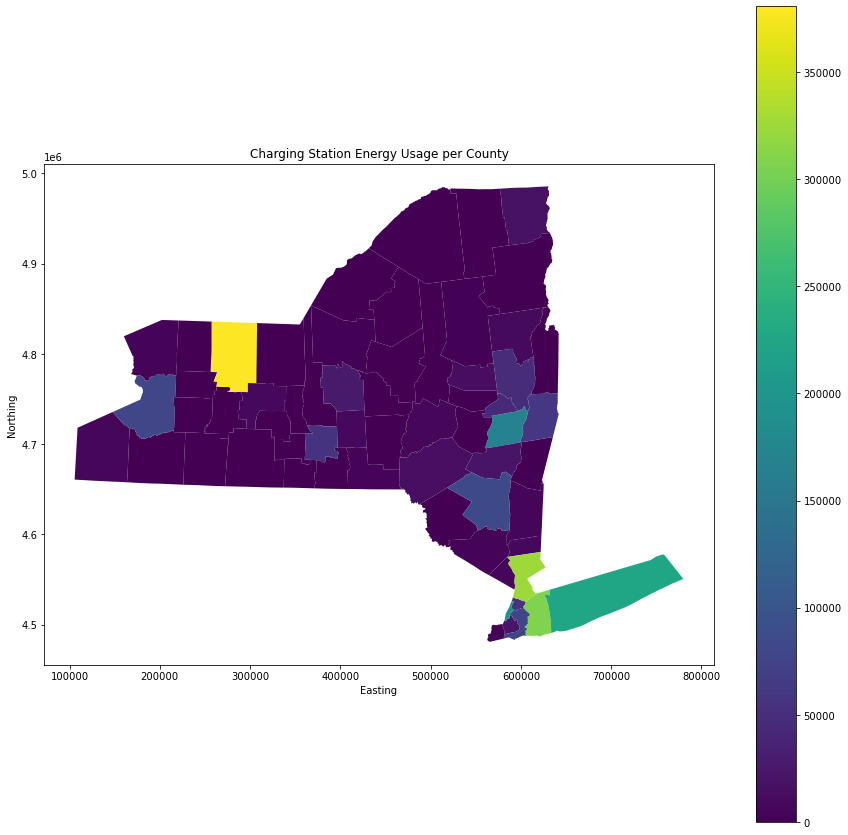

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd

networkData = pd.read_csv("Charging Use by Network.csv")
chargingPortsData = pd.read_csv("Charging Ports by Power Level.csv")

# Obtain county names
name = networkData['County'][0]
# Create dictionary with key being county name and value being total energy usage for county
countyEnergy = {}
total = 0 # total energy usage
index = 0
for row in networkData['County']:
    if(str(row) == name):
        total = total + networkData['Energy (kWh)'][index]
    else:
        countyEnergy[name] = total # adds to dictionary once a new county name is found
        name = str(row)
        total = networkData['Energy (kWh)'][index]
    index += 1
countyEnergy[name] = total

# Create a map based on New York data
NewYorkMap = gpd.read_file("Counties.shp")
energy = [] # total energy usage, parallels county names
for row in NewYorkMap['NAME']:
    r = row + " County"
    if(r in countyEnergy):
        energy.append(countyEnergy[r])
    else:
        energy.append(0) # assigned value of 0 if county name not found
NewYorkMap['ENERGY_(kWh)'] = energy
NewYorkMap.head()

fig,ax = plt.subplots(figsize=(15,15)) # creates heatmap of energy usage of all of New York
NewYorkMap.plot(column="ENERGY_(kWh)", ax=ax, legend=True)
plt.title('Charging Station Energy Usage per County')
plt.xlabel("Easting")
plt.ylabel("Northing")

In a similar way, we can create a heatmap specific to New York County. For our initial RL models, we will primarily be working with data from this county so that the problem can be solved on a smaller scale in a simpler environment.

Text(310.8811010133613, 0.5, 'Northing')

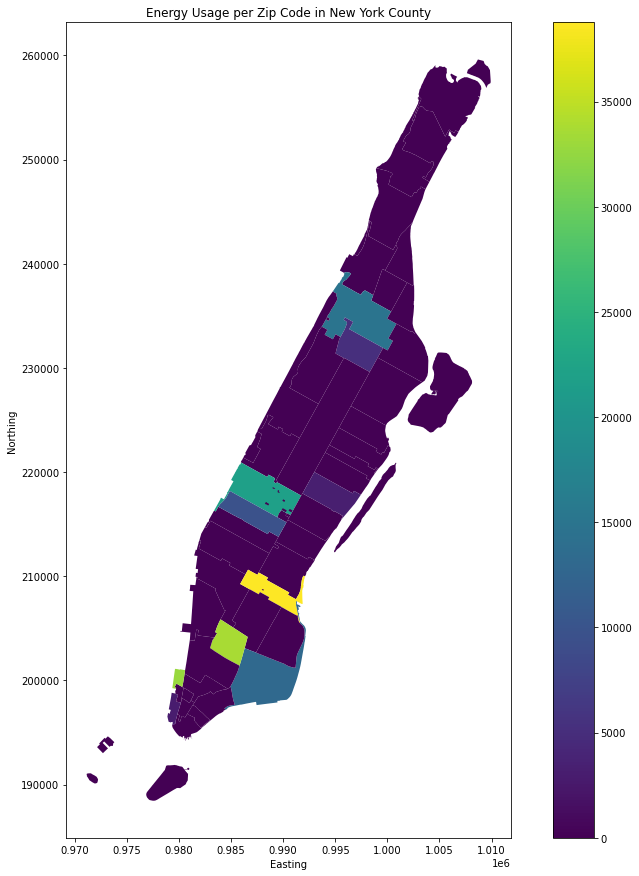

In [19]:
zipToEnergy = {} # dictionary mapping zip codes to energy usage
index = 0
for row in networkData['County']:
    if(row == "New York County"):
        # Add the zip code to New York County if it's in the dictionary
        zipCode = str(networkData['ZIP Code'][index])
        zipToEnergy[zipCode] = networkData['Energy (kWh)'][index]
    index += 1

# Create a map of New York County
NewYorkCountyMap = gpd.read_file("ZIP_CODE_040114.shp")

# Store the energy usage for all counties
energy = [] 
for code in NewYorkCountyMap['ZIPCODE']:
    if(code in zipToEnergy):
        energy.append(zipToEnergy[code])
    else:
        energy.append(0)

# Adds column to the map data
NewYorkCountyMap['Energy (kWh)'] = energy

# Plots counties with energy usage
fig,ax = plt.subplots(figsize=(15,15))
NewYorkCountyMap[NewYorkCountyMap["COUNTY"] == "New York"].plot(column="Energy (kWh)", ax=ax, legend=True)
plt.title('Energy Usage per Zip Code in New York County')
plt.xlabel("Easting")
plt.ylabel("Northing")

Lastly, we can use the charging station location data to plot up the charging locations in New York County:

C:\Users\allen\AppData\Roaming\Python\Python38\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Text(282.0155505066806, 0.5, 'Northing')

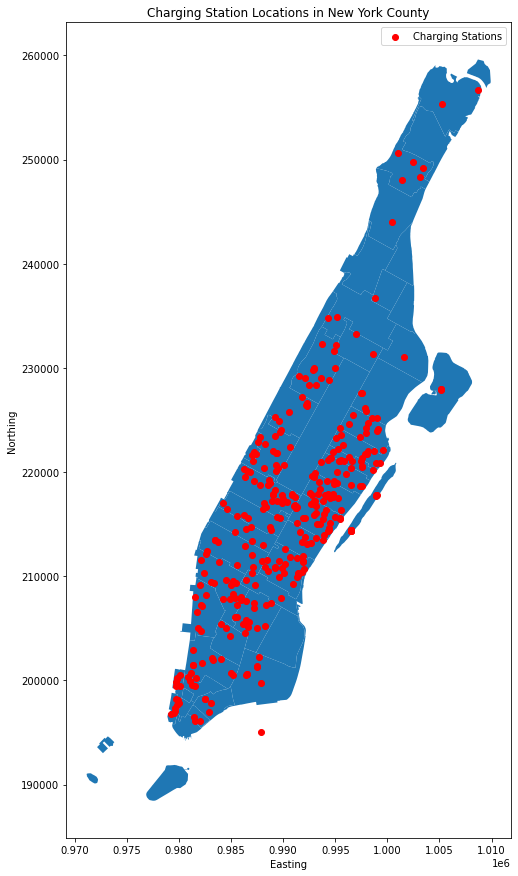

In [20]:
updatedCoords = pd.read_csv("coords.csv") # locations based on charging ports data
updatedCoords.head()

geometry = []
index = 0
# Convert location data to points to be plotted
for row in updatedCoords['spcEasting_usft']:
    long = row.replace(",","")
    lat = updatedCoords['spcNorthing_usft'][index].replace(",","")
    geometry.append(Point(float(long), float(lat)))
    index += 1
crs = {'init': 'EPSG:2263'}
updatedCoords = gpd.GeoDataFrame(updatedCoords, crs=crs, geometry=geometry) # update dataframe

# Plot all chargers in NY County
fig,ax = plt.subplots(figsize=(15,15))
NewYorkCountyMap[NewYorkCountyMap["COUNTY"] == "New York"].plot(ax=ax)
updatedCoords.plot(ax = ax, color='red', label='Charging Stations')
plt.legend()
plt.title("Charging Station Locations in New York County")
plt.xlabel("Easting")
plt.ylabel("Northing")

## Expected Results

We expect that our RL model will be able to find good locations for EV charging stations to best meet the charging demand in a given area of interest. Ideally, the model would be able to take in data from many different locations and be able to "rank" them based on how attractive they are as places to set up a charging station. Each location would eventually be judged in this way, and the model would then be able to pick out the best locations. This decision-making process could be visualized on a map, with certain areas having a higher priority to build a charging station. Overall, this will provide a way to use reinforcement learning to select candidate sites for EV charging station locations in the future, as the infrastructure continues to develop.

## References

Almaghrebi, A., Aljuheshi, F., Rafaie, M. et al. 2020. Data-Driven Charging Demand Prediction at Public Charging Stations Using Supervised Machine Learning Regression Methods. Energies 13(16): 4231.

Flammini, M. G., Prettico, G., Andreea, J. et al. 2019. Statistical characterisation of the real transaction data gathered from electric vehicle charging stations. Electric Power Systems Research 166(1): 136-150. https://doi.org/10.1016/j.epsr.2018.09.022

Gopalakrishnan, R., Biswas, A., Lightwala, A. et al. 2016. Demand Prediction and Placement Optimization for Electric Vehicle Charging Stations. In Proceedings of the Twenty-Fifth International Joint Conference on Artificial Intelligence, New York, NY, July 9-15, 2016.

He, J., Yang, H., Tang, T., et al. 2017. An Optimal Charging Station Location Model With The Consideration of Electric Vehicle’s Driving Range. Transportation Research Part C: Emerging Technologies 86(1): 641-654. https://doi.org/10.1016/j.trc.2017.11.026.

Lam, A., Leung, Y., Chu, X., 2013. Electric vehicle charging station placement. Smart Grid communication, Oct 2013.

Lee, K., A. Ahmed, M., Kang et al. 2020. Deep Reinforcement Learning Based Optimal Route and Charging Station Selection. Energies, Numerical Modeling and Machine Learning Techniques, 27 Nov 2020. https://doi.org/10.3390/en13236255.

Lucas, A., Prettico, G., Flammini, M. G. et al. 2018. Indicator-Based Methodology for Assessing EV Charging Infrastructure Using Exploratory Data Analysis. Energies 11(7): 1869. https://doi.org/10.3390/en11071869. 

Palomino, A., Parvania, M., Zane, R., 2020. Impact of COVID-19 on Mobility and Electric Vehicle Charging Load.

Prabadevi, B., Quoc-Viet, P., Madhusanka,L. et al. 2021. “Deep Learning for Intelligent Demand Response and Smart Grids: A Comprehensive Survey.” 

Shahraki, N., Cai, H., Turkay, M., et al. 2015. Optimal Locations of Electric Public Charging Stations Using Real World Vehicle Travel Patterns. Transportation Research Part D: Transport and Environment 44(1): 165-176. https://doi.org/10.1016/j.trd.2015.09.011.

Wagner, S., Götzinger, M., Neumann, D. 2013. Optimal Location of Charging Stations in Smart Cities: A Point of Interest Based Approach. Thirty Fourth International Conference on Information Systems, Milan, Italy, 15-18 December, 2013. 

Zhu, Juncheng, Yang, Z., Mourshed, M., Guo, Y., Zhou, Y., Chang, Y., Wei, Y., Feng, S., 2019. Electric Vehicle Charging Load Forecasting: A Comparative Study of Deep Learning Approaches. Energies, July 2019.http://dx.doi.org/10.3390/en12142692 


# Aidan's Stuff

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import geopandas as gpd

In [2]:
networkData = pd.read_csv("Charging Use by Network.csv")
networkData.head()

State         County  ZIP Code  Energy (kWh)              Network  \
0  New York  Albany County     12054          2985  ChargePoint Network   
1  New York  Albany County     12077          5225       GE WattStation   
2  New York  Albany County     12110         20652  ChargePoint Network   
3  New York  Albany County     12110         28089       GE WattStation   
4  New York  Albany County     12158          6135  ChargePoint Network   

   Average of Active Port Count  Average of Active Station Count  
0                             2                                1  
1                             2                                2  
2                             2                                1  
3                             3                                3  
4                             1                                1

In [3]:
chargingPortsData = pd.read_csv("Charging Ports by Power Level.csv")
chargingPortsData.head()

Station Name  \
0  40.702004 -73.987053             MPG 100 Jay Street - Tesla Destination   
1  40.704976 -74.009682  Icon Parking 14-26 William Street - Tesla Dest...   
2  40.705042 -74.008118              Andaz Wall Street - Tesla Destination   
3  40.706109 -74.010148         Icon Parking Wall Park - Tesla Destination   
4  40.706643 -74.018095     GGMC Parking Battery Place - Tesla Destination   

     Street Address      City  ZIP Code  Access  \
0        100 Jay St  Brooklyn     10021  Public   
1  14-26 William St  New York     10004  Public   
2        75 Wall St  New York     10005  Public   
3   39  Exchange Pl  New York     10005  Public   
4     50 Battery Pl  New York     10280  Public   

                                    Access Days Time         EV Network  \
0  24 hours daily; for customer use only; see val...  Tesla Destination   
1               24 hours daily; see valet for access  Tesla Destination   
2  24 hours daily; for customer use only; see val...  Tesla Destination   
3               24 hours daily; see valet for access  Tesla Destination   
4      24 hours daily; pay lot; see valet for access  Tesla Destination   

  EV Connector Types  EV On-Site Renewable Source EV Pricing  \
0        J1772 TESLA                          NaN       Free   
1        J1772 TESLA                          NaN       Free   
2        J1772 TESLA                          NaN       Free   
3        J1772 TESLA                          NaN       Free   
4        J1772 TESLA                          NaN       Free   

        Facility Type            Open Date Charging Level  Port Count  
0  Pay-Parking Garage  2017-09-01 00:00:00  Level 2 Ports           3  
1  Pay-Parking Garage  2016-05-01 00:00:00  Level 2 Ports           3  
2             Unknown  2019-03-01 00:00:00  Level 2 Ports           4  
3  Pay-Parking Garage  2017-03-01 00:00:00  Level 2 Ports           3  
4  Pay-Parking Garage  2018-11-01 00:00:00  Level 2 Ports           3

In [4]:
name = networkData['County'][0] # getting all the county names
countyEnergy = {} # creating dictionary with key = county name and value = total energy usage for county
total = 0
index = 0
for row in networkData['County']:
    if(str(row) == name):
        total = total + networkData['Energy (kWh)'][index] # sums energy usage
    else:
        countyEnergy[name] = total # adds to dictionary once new county name is found
        name = str(row)
        total = networkData['Energy (kWh)'][index]
    index += 1
countyEnergy[name] = total

In [6]:
NewYorkMap = gpd.read_file("Counties.shp") # read in the map data of New York

In [7]:
energy = [] # creates list containing total energy usage, that parallels the county names on the New York map
for row in NewYorkMap['NAME']:
    r = row + " County"
    if(r in countyEnergy):
        energy.append(countyEnergy[r])
    else:
        energy.append(0) # if the county name is not in the dictionary, then it is assigned a value of 0
NewYorkMap['ENERGY_(kWh)'] = energy
NewYorkMap.head()

NAME ABBREV GNIS_ID FIPS_CODE    SWIS    NYSP_ZONE  POP1990  \
0       Albany   ALBA  974099     36001  010000         East   292594   
1     Allegany   ALLE  974100     36003  020000         West    50470   
2        Bronx   BRON  974101     36005  600000  Long Island  1203789   
3       Broome   BROO  974102     36007  030000      Central   212160   
4  Cattaraugus   CATT  974103     36009  040000         West    84234   

   POP2000  POP2010  POP2020 DOS_LL DOSLL_DATE NYC   CALC_SQ_MI     DATEMOD  \
0   294565   304204        0   None       None   N   532.791779  2017-11-10   
1    49927    48946        0   None       None   N  1035.209131  2019-04-26   
2  1332650  1385108        0   None       None   Y    57.472148  2019-10-04   
3   200536   200600        0   None       None   N   715.287465  2019-04-26   
4    83955    80317        0   None       None   N  1324.309219  2019-04-26   

      Shape_Leng    Shape_Area  \
0  166077.834242  1.379924e+09   
1  210499.339279  2.681179e+09   
2   57253.861278  1.488522e+08   
3  227933.332021  1.852586e+09   
4  276084.505560  3.429945e+09   

                                            geometry  ENERGY_(kWh)  
0  POLYGON ((605729.038 4737866.883, 606008.186 4...        168340  
1  POLYGON ((229573.870 4712922.870, 229713.780 4...             0  
2  POLYGON ((595540.679 4528518.902, 595766.658 4...         53792  
3  POLYGON ((428899.262 4696276.376, 428927.641 4...          3039  
4  POLYGON ((169747.340 4717358.900, 169915.500 4...             0

Text(108.0, 0.5, 'Northing')

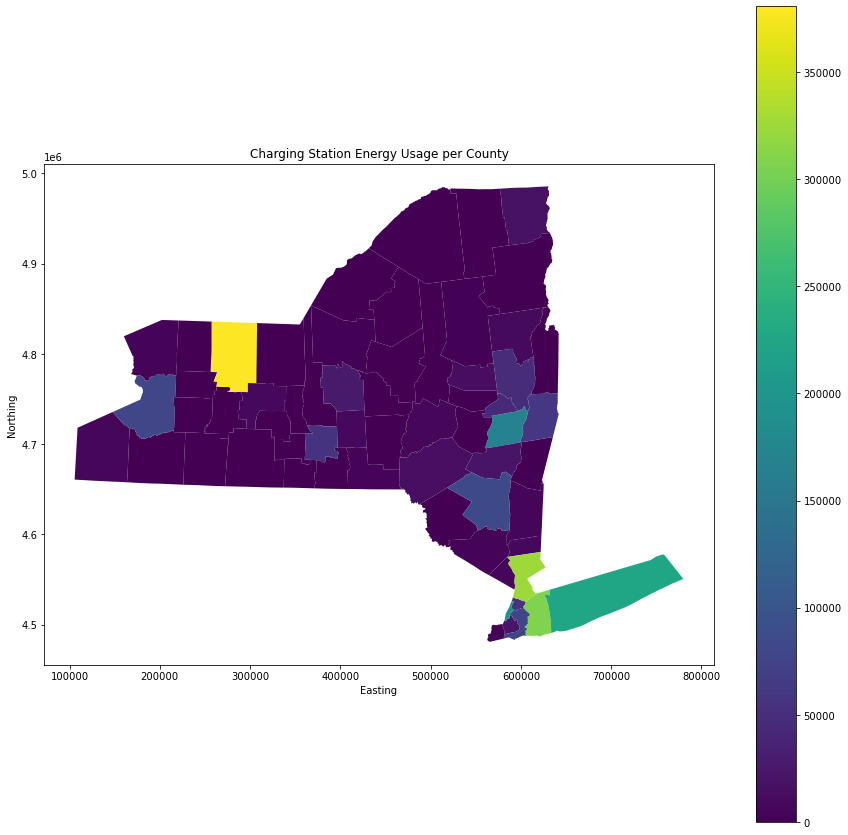

In [8]:
fig,ax = plt.subplots(figsize=(15,15)) # creates heatmap of energy usage of all of New York
NewYorkMap.plot(column="ENERGY_(kWh)", ax=ax, legend=True)
plt.title('Charging Station Energy Usage per County')
plt.xlabel("Easting")
plt.ylabel("Northing")

In [9]:
zipToEnergy = {} # dictionary with key = zip code and value = energy usage
index = 0
for row in networkData['County']:
    if(row == "New York County"):
        # if the zip code is in New York County, then it is added to dictionary
        zipCode = str(networkData['ZIP Code'][index])
        zipToEnergy[zipCode] = networkData['Energy (kWh)'][index]
    index += 1

In [10]:
NewYorkCountyMap = gpd.read_file("ZIP_CODE_040114.shp") # reads in the map data of New York County

In [11]:
energy = [] # list that has the energy usage for all the counties
for code in NewYorkCountyMap['ZIPCODE']:
    if(code in zipToEnergy):
        energy.append(zipToEnergy[code])
    else:
        energy.append(0) # if not in dictionary then assigned value of 0
    
NewYorkCountyMap['Energy (kWh)'] = energy # adds column to the map data
NewYorkCountyMap.head()

ZIPCODE BLDGZIP   PO_NAME  POPULATION          AREA STATE  COUNTY ST_FIPS  \
0   11436       0   Jamaica     18681.0  2.269930e+07    NY  Queens      36   
1   11213       0  Brooklyn     62426.0  2.963100e+07    NY   Kings      36   
2   11212       0  Brooklyn     83866.0  4.197210e+07    NY   Kings      36   
3   11225       0  Brooklyn     56527.0  2.369863e+07    NY   Kings      36   
4   11218       0  Brooklyn     72280.0  3.686880e+07    NY   Kings      36   

  CTY_FIPS                   URL  SHAPE_AREA  SHAPE_LEN  \
0      081  http://www.usps.com/         0.0        0.0   
1      047  http://www.usps.com/         0.0        0.0   
2      047  http://www.usps.com/         0.0        0.0   
3      047  http://www.usps.com/         0.0        0.0   
4      047  http://www.usps.com/         0.0        0.0   

                                            geometry  Energy (kWh)  
0  POLYGON ((1038098.252 188138.380, 1038141.936 ...             0  
1  POLYGON ((1001613.713 186926.440, 1002314.243 ...             0  
2  POLYGON ((1011174.276 183696.338, 1011373.584 ...             0  
3  POLYGON ((995908.365 183617.613, 996522.848 18...             0  
4  POLYGON ((991997.113 176307.496, 992042.798 17...             0

Text(310.8811010133613, 0.5, 'Northing')

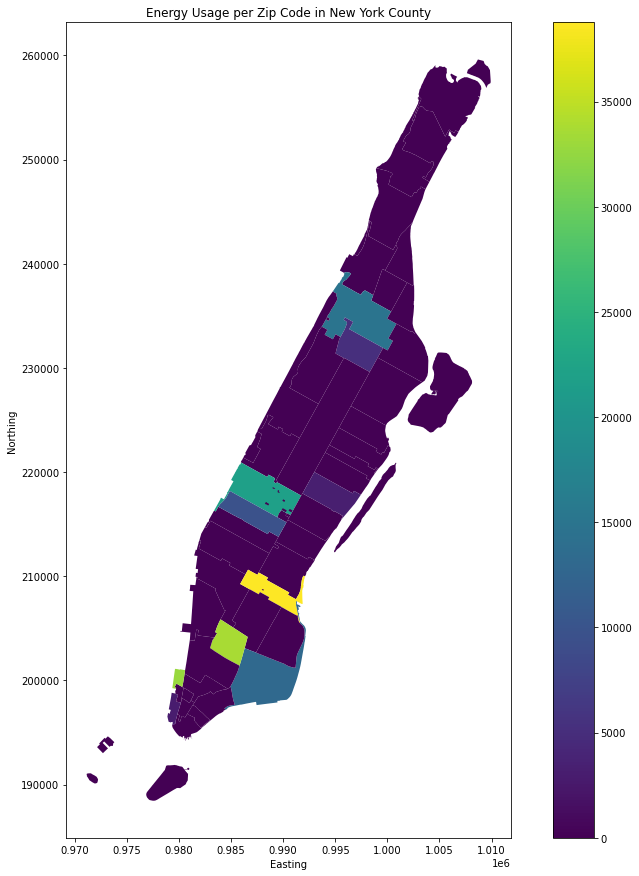

In [12]:
fig,ax = plt.subplots(figsize=(15,15)) # plots the county with energy usage
NewYorkCountyMap[NewYorkCountyMap["COUNTY"] == "New York"].plot(column="Energy (kWh)", ax=ax, legend=True)
plt.title('Energy Usage per Zip Code in New York County') # plots map
plt.xlabel("Easting")
plt.ylabel("Northing")

In [13]:
updatedCoords = pd.read_csv("coords.csv") #transformed locations based on chargingPortsData
updatedCoords.head()

ID  nadconVersion  vertconVersion     srcDatum    destDatum srcVertDatum  \
0   1            5.0             3.0  NAD83(2011)  NAD83(2011)       NAVD88   
1   2            5.0             3.0  NAD83(2011)  NAD83(2011)       NAVD88   
2   3            5.0             3.0  NAD83(2011)  NAD83(2011)       NAVD88   
3   4            5.0             3.0  NAD83(2011)  NAD83(2011)       NAVD88   
4   5            5.0             3.0  NAD83(2011)  NAD83(2011)       NAVD88   

  destVertDatum     srcLat      srcLatDms    destLat  ...      utmZone  \
0        NAVD88  40.702004  N404207.21440  40.702004  ...  UTM Zone 18   
1        NAVD88  40.704976  N404217.91360  40.704976  ...  UTM Zone 18   
2        NAVD88  40.705042  N404218.15120  40.705042  ...  UTM Zone 18   
3        NAVD88  40.706109  N404221.99240  40.706109  ...  UTM Zone 18   
4        NAVD88  40.706643  N404223.91480  40.706643  ...  UTM Zone 18   

     utmNorthing   utmEasting  utmConvergence utmScaleFactor  \
0  4,506,170.857  585,573.598     00 39 38.19       0.999690   
1  4,506,478.971  583,658.155     00 38 45.19       0.999686   
2  4,506,487.788  583,790.195     00 38 48.87       0.999686   
3  4,506,604.298  583,617.371     00 38 44.15       0.999686   
4  4,506,656.041  582,945.379     00 38 25.52       0.999685   

   utmCombinedFactor   x   y   z             usng  
0                NaN NaN NaN NaN  18TWL8557306170  
1                NaN NaN NaN NaN  18TWL8365806478  
2                NaN NaN NaN NaN  18TWL8379006487  
3                NaN NaN NaN NaN  18TWL8361706604  
4                NaN NaN NaN NaN  18TWL8294506656  

[5 rows x 47 columns]

In [14]:
geometry = []
index = 0
for row in updatedCoords['spcEasting_usft']: # turn all the location data into points to be plotted
    long = row.replace(",","")
    lat = updatedCoords['spcNorthing_usft'][index].replace(",","")
    geometry.append(Point(float(long), float(lat)))
    index += 1
crs = {'init': 'EPSG:2263'}
updatedCoords = gpd.GeoDataFrame(updatedCoords, crs=crs, geometry=geometry) #updated the dataframe to include points

C:\Users\allen\AppData\Roaming\Python\Python38\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


Text(282.5155505066806, 0.5, 'Northing')

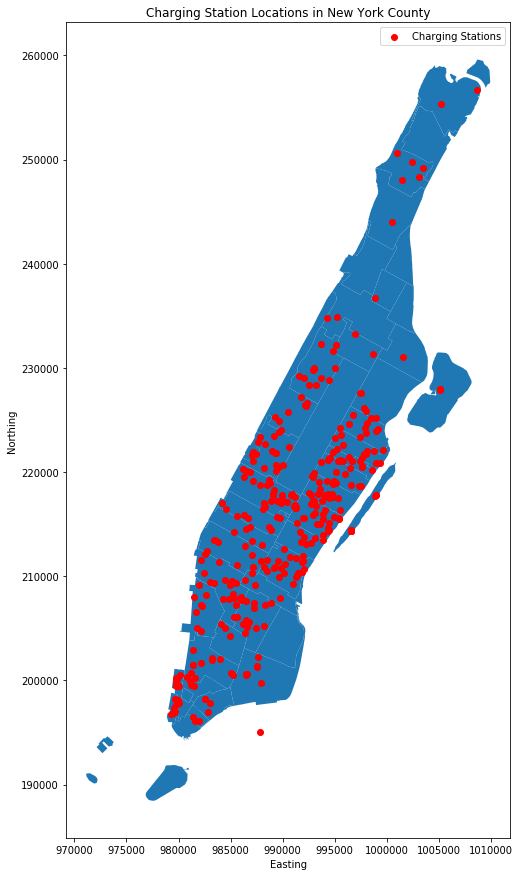

In [14]:
fig,ax = plt.subplots(figsize=(15,15)) # plotting all the chargers in New York County
NewYorkCountyMap[NewYorkCountyMap["COUNTY"] == "New York"].plot(ax=ax)
updatedCoords.plot(ax = ax, color='red', label='Charging Stations')
plt.legend()
plt.title("Charging Station Locations in New York County")
plt.xlabel("Easting")
plt.ylabel("Northing")